In [43]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt

### Generar Conjuntos de Datos Más Desafiantes pero Linealmente Separables

In [44]:
def generate_challenging_data(N, D, separation=0.1, random_seed=None):
    np.random.seed(random_seed)
    X_pos = np.random.randn(N, D) + separation
    X_neg = np.random.randn(N, D) - separation
    X = np.vstack((X_pos, X_neg))
    y = np.hstack((np.ones(N), -np.ones(N)))
    return X, y


### Entrenar el Perceptrón y Registrar la Evolución de los Pesos

In [45]:
def perceptron(X, y, learning_rate_func, epochs=1000):
    X_bias = np.hstack((np.ones((X.shape[0], 1)), X))  # Add bias term
    weights = np.zeros(X_bias.shape[1])
    errors = []
    
    for epoch in range(1, epochs + 1):
        learning_rate = learning_rate_func(epoch)
        total_error = 0
        for xi, target in zip(X_bias, y):
            activation = np.dot(weights, xi)
            output = 1 if activation >= 0 else -1
            if output != target:
                update = learning_rate * (target - output)
                weights += update * xi
                total_error += 1
        errors.append(total_error)
        if total_error == 0:
            # Continue adding zeros to keep the same length
            while len(errors) < epochs:
                errors.append(0)
            break
    return weights, errors


### Entrenar con Diferentes Tasas de Aprendizaje y Graficar Error vs. Épocas

In [46]:
def constant_lr(lr):
    return lambda epoch: lr

def decreasing_lr(initial_lr):
    return lambda epoch: initial_lr / epoch

def exponential_decay_lr(initial_lr, decay_rate):
    return lambda epoch: initial_lr * np.exp(-decay_rate * epoch)


In [47]:
def compute_margin(weights):
    return 1.0 / np.linalg.norm(weights[1:])  # Excluir el término de sesgo


In [48]:
N = 100       # Número de muestras por clase
D = 1000000      # Número de características (dimensiones)
separation = 0.00001
num_runs = 10  # Número de ejecuciones con diferentes semillas aleatorias
max_epochs = 10  # Máximo número de épocas para el entrenamiento del perceptrón

learning_rate_functions = {
    'Constante LR=0.01': constant_lr(0.01),
    'Constante LR=0.001': constant_lr(0.001),
    'Decreciente LR': decreasing_lr(1.0),
    'Decaimiento Exponencial LR': exponential_decay_lr(1.0, decay_rate=0.1)
}

errors_per_learning_rate = {label: [] for label in learning_rate_functions.keys()}
perceptron_margins_per_learning_rate = {label: [] for label in learning_rate_functions.keys()}
svm_margins_per_run = []
angles_per_learning_rate = {label: [] for label in learning_rate_functions.keys()}

In [49]:
for run in range(num_runs):
    # Generate dataset with a specific random seed
    X, y = generate_challenging_data(N, D, separation=separation, random_seed=run)
    
    # Train SVM on the same dataset
    clf = svm.LinearSVC(loss='hinge', max_iter=10000, random_state=run, tol=1e-6)
    clf.fit(X, y)
    w_svm = np.hstack((clf.intercept_[0], clf.coef_[0]))
    
    # Normalize SVM weight vector (excluding bias)
    w_svm_norm = w_svm[1:] / np.linalg.norm(w_svm[1:])
    
    for label, lr_func in learning_rate_functions.items():
        # Train perceptron
        weights, errors = perceptron(X, y, learning_rate_func=lr_func, epochs=max_epochs)
        
        # Normalize perceptron weight vector (excluding bias)
        w_perceptron_norm = weights[1:] / np.linalg.norm(weights[1:])
        
        # Compute the angle between the hyperplanes
        cosine_similarity = np.dot(w_perceptron_norm, w_svm_norm)
        # Ensure the value is within the valid range for arccos
        cosine_similarity = np.clip(cosine_similarity, -1.0, 1.0)
        angle = np.arccos(cosine_similarity) * (180.0 / np.pi)  # Convert to degrees
        
        # Store the angle
        angles_per_learning_rate[label].append(angle)


### Procesar y Analizar los Resultados

Calcular la Media y Desviación Estándar de los Errores a lo Largo de las Épocas:

In [50]:
angles_mean = {}
angles_std = {}

for label in learning_rate_functions.keys():
    angles = angles_per_learning_rate[label]
    angles_mean[label] = np.mean(angles)
    angles_std[label] = np.std(angles)


### Graficar Angulos

C:\Users\Tomas\AppData\Local\Temp\ipykernel_16904\2825121224.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x_pos, mean_angles, yerr=std_angles, fmt='o', ecolor='black', capsize=10, linestyle='None', marker='o', markersize=8, alpha=0.7)


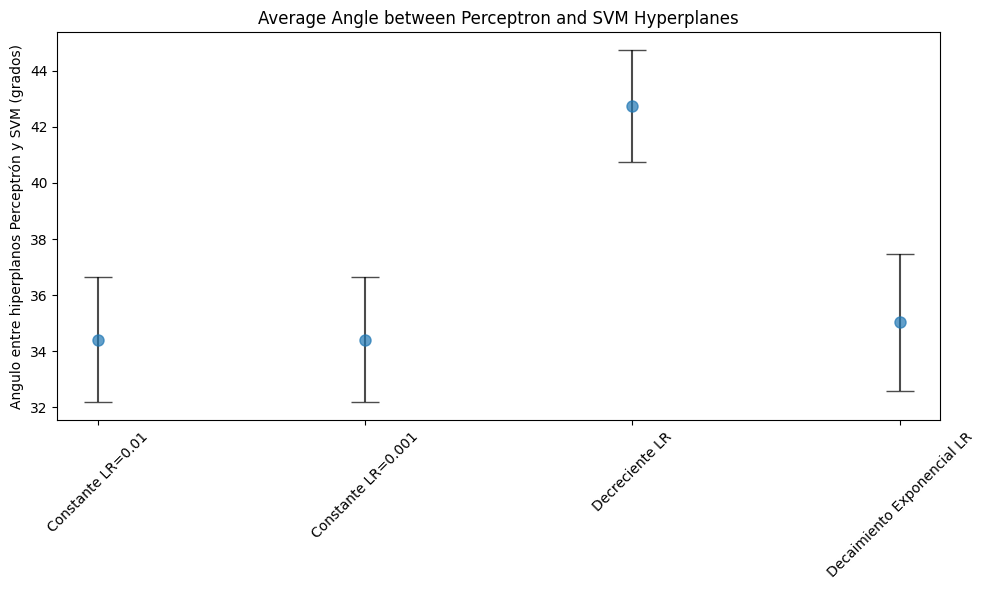

In [53]:
labels = list(learning_rate_functions.keys())
mean_angles = [angles_mean[label] for label in labels]
std_angles = [angles_std[label] for label in labels]

plt.figure(figsize=(10, 6))
x_pos = np.arange(len(labels))
plt.errorbar(x_pos, mean_angles, yerr=std_angles, fmt='o', ecolor='black', capsize=10, linestyle='None', marker='o', markersize=8, alpha=0.7)
plt.xticks(x_pos, labels, rotation=45)
plt.ylabel('Angulo entre hiperplanos Perceptrón y SVM (grados)')
plt.title('Average Angle between Perceptron and SVM Hyperplanes')
plt.tight_layout()
plt.show()